We have a bunch of probably chess x-corners output by our ML detector. Let's try to fit lines to them.

Populating the interactive namespace from numpy and matplotlib


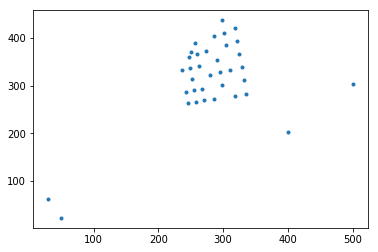

In [8]:
%pylab inline
from IPython.display import Image, display
import PIL.Image
import matplotlib.image as mpimg
import scipy.ndimage
import cv2 # For Sobel etc
np.set_printoptions(suppress=True) # Better printing of arrays
plt.rcParams['image.cmap'] = 'jet' # Default colormap is jet

pts = np.loadtxt('example_pts.txt')
plt.plot(pts[:,0],pts[:,1],'.')

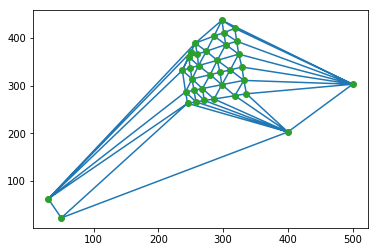

In [163]:
from scipy.spatial import Delaunay

tri = Delaunay(pts)
plt.triplot(pts[:,0], pts[:,1], tri.simplices.copy())
plt.plot(pts[:,0], pts[:,1], 'o')

In [169]:
for triangle in pts[tri.simplices]:
    print(triangle)

[[ 50.  23.]
 [245. 263.]
 [ 30.  63.]]
[[ 50.  23.]
 [400. 203.]
 [245. 263.]]
[[318. 279.]
 [336. 283.]
 [332. 311.]]
[[336. 283.]
 [318. 279.]
 [400. 203.]]
[[332. 311.]
 [336. 283.]
 [500. 303.]]
[[336. 283.]
 [400. 203.]
 [500. 303.]]
[[298. 437.]
 [318. 420.]
 [500. 303.]]
[[298. 302.]
 [318. 279.]
 [332. 311.]]
[[329. 339.]
 [332. 311.]
 [500. 303.]]
[[324. 366.]
 [329. 339.]
 [500. 303.]]
[[321. 393.]
 [324. 366.]
 [500. 303.]]
[[318. 420.]
 [321. 393.]
 [500. 303.]]
[[268. 294.]
 [298. 302.]
 [280. 323.]]
[[311. 333.]
 [298. 302.]
 [332. 311.]]
[[329. 339.]
 [311. 333.]
 [332. 311.]]
[[311. 333.]
 [329. 339.]
 [324. 366.]]
[[291. 353.]
 [311. 333.]
 [324. 366.]]
[[257. 389.]
 [274. 372.]
 [286. 404.]]
[[257. 389.]
 [286. 404.]
 [298. 437.]]
[[237. 332.]
 [249. 337.]
 [247. 360.]]
[[301. 411.]
 [321. 393.]
 [318. 420.]]
[[286. 404.]
 [301. 411.]
 [298. 437.]]
[[301. 411.]
 [318. 420.]
 [298. 437.]]
[[274. 372.]
 [304. 386.]
 [286. 404.]]
[[304. 386.]
 [301. 411.]
 [286. 404.]]


In [164]:
%%time
tri = Delaunay(pts)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 695 µs


In [13]:
np.linalg.norm(pts.max(axis=0))

array([500., 437.])

In [77]:
def uninformedHough(points, theta_bin_size=100, rho_bin_size=100):
    """Return uninformed hough space from points"""
    thetas = np.linspace(0,np.pi,theta_bin_size)
    max_rho = np.linalg.norm(pts.max(axis=0))
    rhos = np.linspace(0, max_rho,rho_bin_size) # length of diagonal
    hough_space = np.zeros([theta_bin_size, rho_bin_size], dtype=np.uint8)
    
    for i,j in pts:
        for t,theta in enumerate(thetas):
            rho = j*np.cos(theta) + i*np.sin(theta)
            rho_idx = np.searchsorted(rhos, rho) # Get bin index for rhos
            hough_space[t-1:t+2, rho_idx-1:rho_idx+2] += 1
            hough_space[t, rho_idx] += 1

    return (hough_space, thetas, rhos)

In [78]:
%%time
h, thetas, rhos = uninformedHough(pts, theta_bin_size=2*180, rho_bin_size=1*600)

CPU times: user 472 ms, sys: 0 ns, total: 472 ms
Wall time: 468 ms


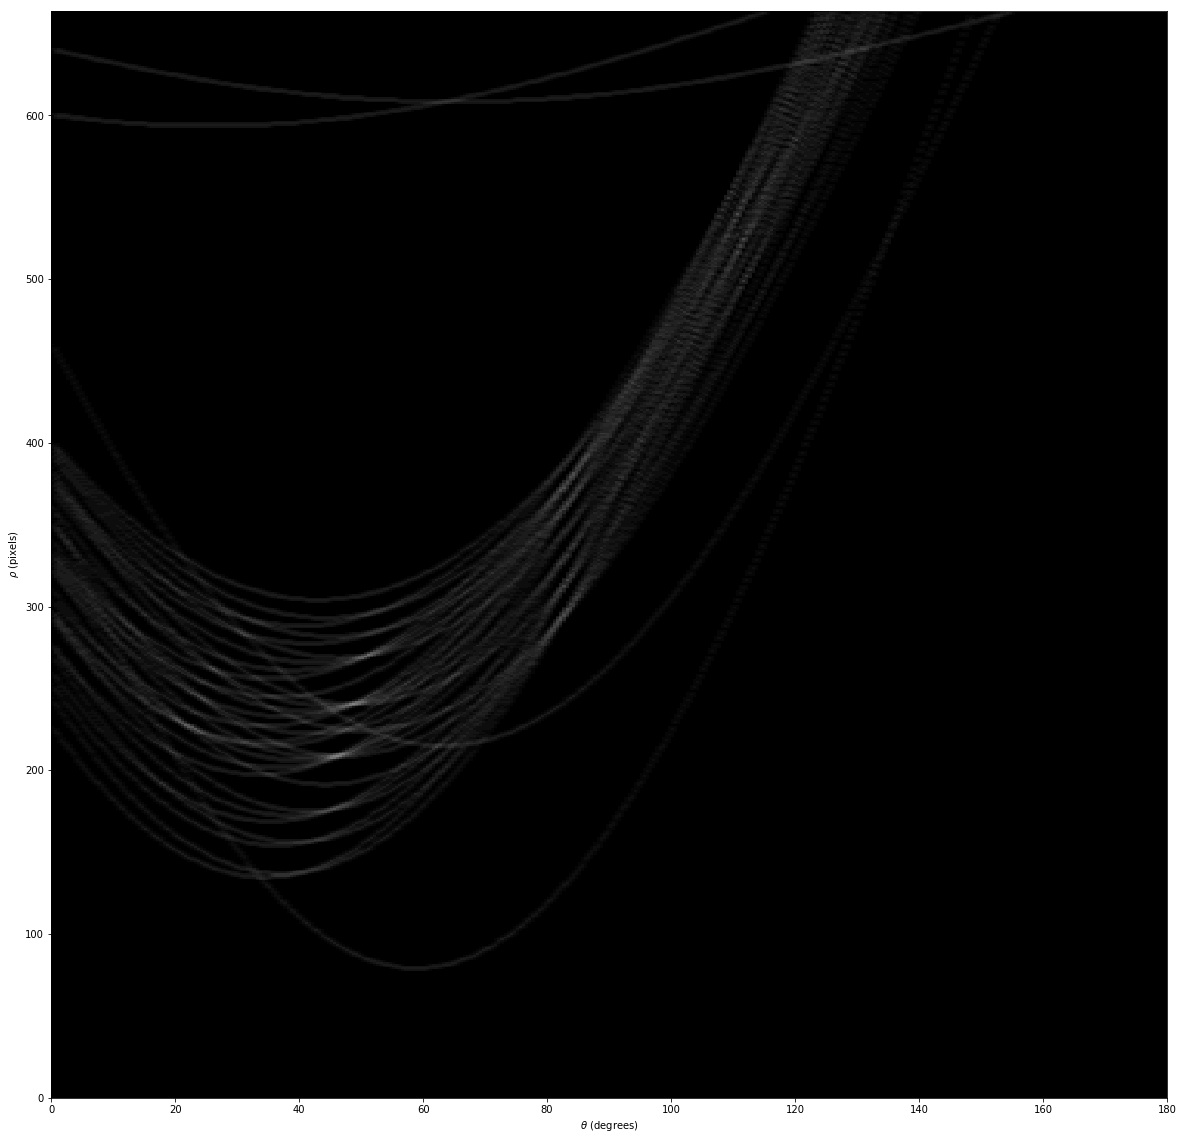

In [79]:
fig = plt.figure(figsize=(20,20))
plt.imshow(h.T, interpolation='none', extent=[thetas[0]*180/np.pi, thetas[-1]*180/np.pi, rhos[0], rhos[-1]], cmap=cm.gray)
plt.xlabel(r'$\theta}$ (degrees)')
plt.ylabel(r'$\rho}$ (pixels)')
plt.axis('normal')
plt.axis('tight');

In [80]:
def fast_nonmax_sup(img_in, win=21):
    img = img_in.copy()
    element = np.ones([win, win], np.uint8)
#     img = cv2.blur(img, (5,5))
    img_dilate = cv2.dilate(img, element)
    peaks = cv2.compare(img, img_dilate, cv2.CMP_EQ)
    # nonzeroImg = cv2.compare(img, 0, cv2.CMP_NE)
    # peaks = cv2.bitwise_and(peaks, nonzeroImg)
    # peaks[img == 0] = 0
    # notPeaks = cv2.bitwise_not(peaks)

    img[peaks == 0] = 0
    return img

In [141]:
h_peaks = h.copy()
h_peaks[h_peaks<3] = 0
h_peaks = fast_nonmax_sup(h_peaks)

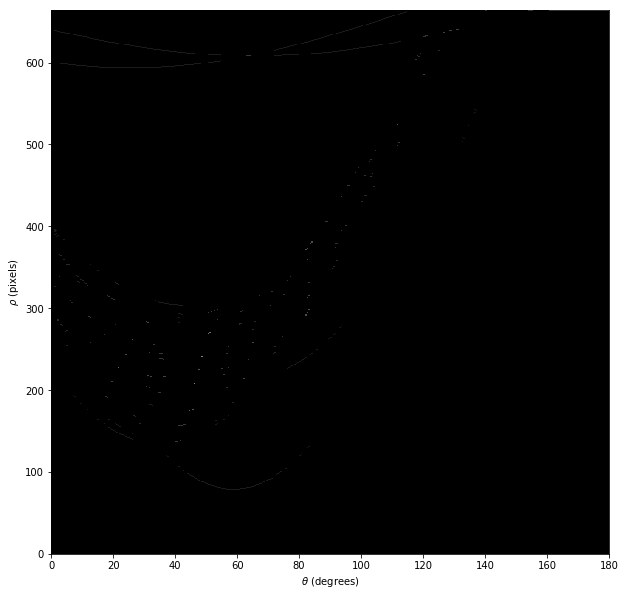

In [142]:
fig = plt.figure(figsize=(10,10))
plt.imshow(h_peaks.T, interpolation='none', extent=[thetas[0]*180/np.pi, thetas[-1]*180/np.pi, rhos[0], rhos[-1]], cmap=cm.gray)
plt.xlabel(r'$\theta}$ (degrees)')
plt.ylabel(r'$\rho}$ (pixels)')
plt.axis('normal')
plt.axis('tight');

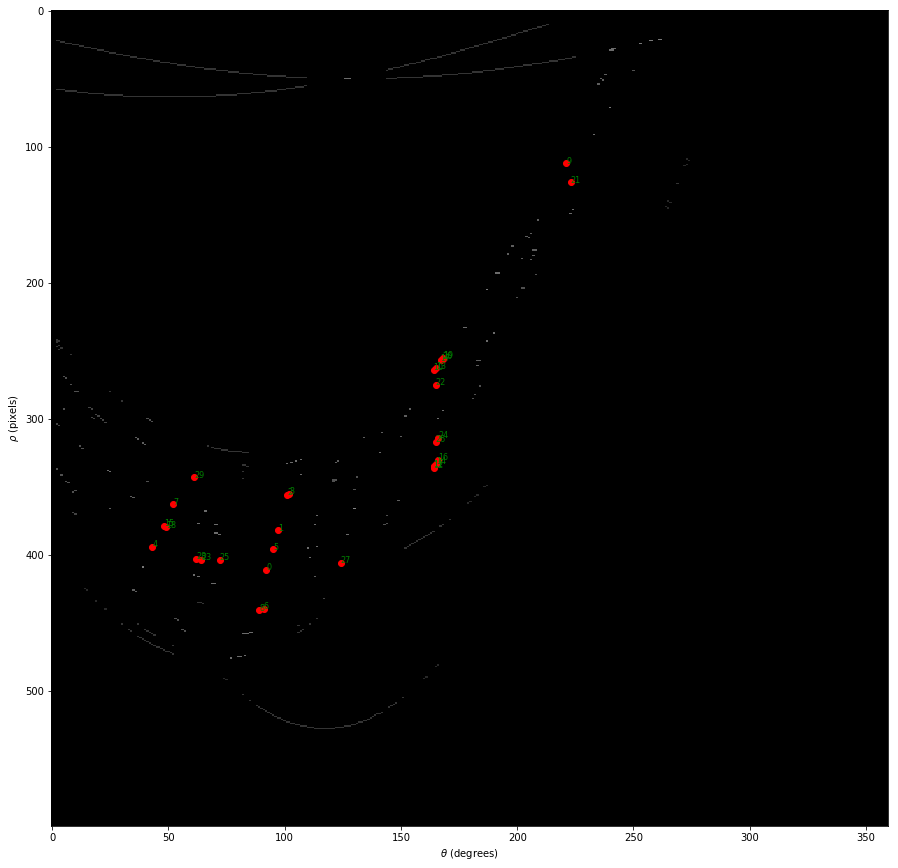

In [149]:
h_peaks[:,:10] = 0
pot_vals = np.argwhere(h_peaks)
pot_scores = h_peaks[pot_vals[:,0], pot_vals[:,1]]
pot_order = np.argsort(pot_scores)[::-1]

pot_pts_ordered = pot_vals[pot_order,:]
pot_scores_ordered = pot_scores[pot_order]
n_peaks = 30


fig = plt.figure(figsize=(15,15))
plt.imshow(h_peaks.T, interpolation='none', cmap=cm.gray)
plt.plot(pot_pts_ordered[:n_peaks,0], pot_pts_ordered[:n_peaks, 1], 'or')
plt.xlabel(r'$\theta}$ (degrees)')
plt.ylabel(r'$\rho}$ (pixels)')
plt.axis('normal')
plt.axis('tight');

for idx, (px, py) in enumerate(pot_pts_ordered[:n_peaks,:]):
    plt.text(px, py,'%s' % idx, color='green', size=8)


In [144]:
def getHoughLines(peaks, thetas, rhos, img_shape):
    # lines segments within image bounds x1 y1 x2 y2
    lines = np.zeros([peaks.shape[0],4])
    
    for i, [theta_, rho_] in enumerate(peaks):
        theta = thetas[theta_]
        rho = rhos[rho_]
        c = np.cos(theta)
        s = np.sin(theta)
        
        img_x_max = img_shape[1]-1
        img_y_max = img_shape[0]-1
#         print("sin:",s)
#         print("cos:",c)
#         print(theta*180/np.pi,rho)

        if np.abs(c) < np.abs(s):
            # angle is closer to 0 or 180 degrees, horizontal line so use x limits
#             print("H")
            x1 = 0
            x2 = img_x_max
            y1 = (rho - x1*c)/s
            y2 = (rho - x2*c)/s
        else:
            # angle closer to 90 degrees, vertical line so use y limits
#             print("V")
            y1 = 0
            y2 = img_y_max
            x1 = (rho - y1*s)/c
            x2 = (rho - y2*s)/c
        
#         print(x1, y1, x2, y2)

        # Get line ends within image bounds
        # TODO : Fails on very close to vertical/horizontal lines due to divide by ~zero
        if (np.abs(s) > 0.01 and np.abs(c) > 0.01):
            if (y1 < 0):
                x1 = (rho - 0*s)/c
                y1 = (rho - x1*c)/s
            elif (y1 > img_y_max):
                x1 = (rho - img_y_max*s)/c
                y1 = (rho - x1*c)/s
            if (y2 < 0):
                x2 = (rho - 0*s)/c
                y2 = (rho - x2*c)/s
            elif (y2 > img_y_max):
                x2 = (rho - img_y_max*s)/c
                y2 = (rho - x2*c)/s

            if (x1 < 0):
                y1 = (rho-0*c)/s
                x1 = (rho - y1*s)/c
            elif (x1 > img_x_max):
                y1 = (rho - img_x_max*c)/s
                x1 = (rho - y1*s)/c
            if (x2 < 0):
                y2 = (rho-0*c)/s
                x2 = (rho - y2*s)/c
            elif (x2 > img_x_max):
                y2 = (rho - img_x_max*c)/s
                x2 = (rho - y2*s)/c

        lines[i,:] = [x1, y1, x2, y2]

    return lines

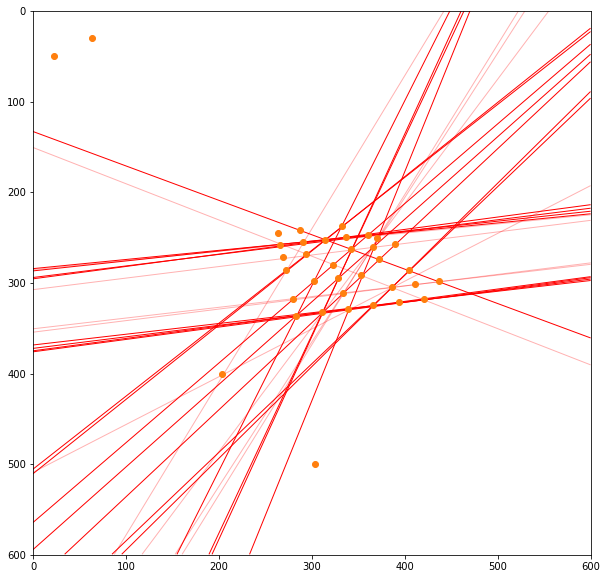

In [160]:
fig = plt.figure(figsize=(10,10))
# plt.imshow(img_orig);
plt.plot(pts[:,1],pts[:,0],'.')
plt.axis([0,600,600,0])

lines = getHoughLines(pot_pts_ordered[:n_peaks,:], thetas, rhos, [600,600])

for i, [x1,y1,x2,y2] in enumerate(lines):
#     alpha_ = 1.0 if i < min(peaks.shape[0],20) else 0.3 # Make first 20 lines strongest
    alpha_ = 1.0 if i < 20 else 0.3
    plt.plot([x1,x2], [y1,y2],'r-', alpha=alpha_, lw=1)
    
plt.plot(pts[:,1],pts[:,0],'o')